In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cpu
cpu


## 加载数据

In [25]:
from torchvision import datasets  # 导入 torchvision 中的 datasets 模块，该模块包含了常用的图像数据集，如 MNIST、FashionMNIST 等
from torchvision.transforms import ToTensor  # 导入 torchvision.transforms 中的 ToTensor 类，用于将图像转换为 Tensor 格式，同时将像素值归一化到 [0, 1] 的范围内

# fashion_mnist图像分类数据集
train_ds = datasets.FashionMNIST(
    root="data",           # 指定数据集的根目录为 "data"，如果数据集不存在于该目录中，则会下载到这里
    train=True,            # 指定加载训练集数据；设置为 True 表示加载训练数据部分
    download=True,         # 如果数据集文件不存在，则自动从互联网上下载
    transform=ToTensor()   # 应用 ToTensor 转换，将图像从 PIL 格式转换为 Tensor 格式，同时将像素值从 [0, 255] 映射到 [0, 1]
)

test_ds = datasets.FashionMNIST(
    root="data",           # 指定数据集的根目录为 "data"，与训练集保持一致，确保数据下载到同一位置
    train=False,           # 指定加载测试集数据；设置为 False 表示加载测试数据部分
    download=True,         # 同样，如果测试数据不存在，则自动下载
    transform=ToTensor()   # 对测试图像同样应用 ToTensor 转换，保持与训练数据一致的预处理步骤
)

# torchvision 数据集里没有提供训练集和验证集的划分
# 当然也可以用 torch.utils.data.Dataset 实现人为划分
# 从数据集到 dataloader

# 创建 DataLoader 对象，用于将训练数据集封装为批次数据，便于模型训练
train_loader = torch.utils.data.DataLoader(
    train_ds,             # 使用之前定义的训练数据集
    batch_size=16,        # 指定每个批次的样本数量为 16
    shuffle=True          # 在每个 epoch 开始前将训练数据随机打乱，有助于提升模型训练效果，防止模型记住数据顺序
)

# 创建 DataLoader 对象，用于将测试数据集封装为批次数据，便于模型验证或测试
val_loader = torch.utils.data.DataLoader(
    test_ds,              # 使用之前定义的测试数据集
    batch_size=16,        # 指定每个批次的样本数量为 16
    shuffle=False         # 测试集一般不需要打乱顺序，因为评估时保持数据顺序可以方便结果复现和对比
)


In [26]:
# 导入必要的库
from torchvision.transforms import Normalize  # 导入标准化处理类
import torch.nn as nn  # 导入神经网络模块

# 计算数据集各通道的均值和标准差
def cal_mean_std(ds):
    # 注意：此处初始化应为张量，使用浮点数可能导致类型错误
    mean = 0.  # 初始化均值（应为torch.Tensor类型）
    std = 0.   # 初始化标准差（应为torch.Tensor类型）
    
    # 遍历数据集中的每个样本
    for img, _ in ds:  # img形状为[1,28,28]（单通道灰度图）
        # 在高度和宽度维度计算均值/std，得到形状[1]的张量
        mean += img.mean(dim=(1, 2))  # 当前图片的通道均值
        std += img.std(dim=(1, 2))    # 当前图片的通道标准差
        
    # 计算整个数据集的平均均值/标准差
    mean /= len(ds)  # 各图片均值的平均值
    std /= len(ds)   # 各图片标准差的平均值
    return mean, std  # 返回统计结果

# 打印训练集统计量（注意可能因类型问题报错）
print(cal_mean_std(train_ds))  # 预期输出：(tensor([0.2860]), tensor([0.3205]))

# 构建数据预处理流水线
transforms = nn.Sequential(
    # 标准化处理：input[channel] = (input[channel] - mean[channel]) / std[channel]
    # 使用训练集计算的统计量，适用于单通道数据
    Normalize([0.2860], [0.3205])  # 参数形式：[通道1均值], [通道1标准差]
)

"""
代码注意事项：
1. 原始代码存在类型错误风险，建议将mean/std初始化为torch.Tensor：
   mean = torch.zeros(1)
   std = torch.zeros(1)

2. Normalize的参数需要与输入数据的通道数匹配，这里处理的是MNIST单通道数据

3. 标准化参数应使用训练集计算结果，测试集应使用相同的参数

4. 使用nn.Sequential允许组合多个预处理操作（后续可添加其他变换）

5. 实际使用时需确保输入数据已转换为Tensor格式
"""

(tensor([0.2860]), tensor([0.3205]))


'\n代码注意事项：\n1. 原始代码存在类型错误风险，建议将mean/std初始化为torch.Tensor：\n   mean = torch.zeros(1)\n   std = torch.zeros(1)\n\n2. Normalize的参数需要与输入数据的通道数匹配，这里处理的是MNIST单通道数据\n\n3. 标准化参数应使用训练集计算结果，测试集应使用相同的参数\n\n4. 使用nn.Sequential允许组合多个预处理操作（后续可添加其他变换）\n\n5. 实际使用时需确保输入数据已转换为Tensor格式\n'

## 定义模型

这里我们没有用`nn.Linear`的默认初始化，而是采用了xavier均匀分布去初始化全连接层的权重

xavier初始化出自论文 《Understanding the difficulty of training deep feedforward neural networks》，适用于使用`tanh`和`sigmoid`激活函数的方法。当然，我们这里的模型采用的是`relu`激活函数，采用He初始化（何凯明初始化）会更加合适。感兴趣的同学可以自己动手修改并比对效果。

|神经网络层数|初始化方式|early stop at epoch| val_loss | vla_acc|
|-|-|-|-|-|
|20|默认|
|20|xaviier_uniform|
|20|he_uniform|
|...|

He初始化出自论文 《Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification》

In [27]:
import torch.nn as nn
import numpy as np

class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        """定义神经网络结构
        Args:
            layers_num (int): 隐藏层的数量（包含初始层，例如layers_num=2时，实际包含初始层+循环添加的1层）
                              （当layers_num=20时，会构建 20 个隐藏层）
        """
        super().__init__()
        
        # 预处理层：标准化（需确保输入数据已被转换为Tensor）
        self.transforms = transforms  # 从外部传入的标准化转换
        
        # 展平层：将二维图像数据压平为一维向量（例如[1,28,28] -> [784]）
        self.flatten = nn.Flatten()
        
        # 构建全连接层堆栈（初始层）
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 100),  # 输入层：784 -> 100
            nn.ReLU()                 # 激活函数
        )
        
        # 动态添加隐藏层（当layers_num=20时，此处循环19次，共添加19层）
        # 注意：初始已包含1层，因此循环次数为 layers_num-1 次
        for i in range(1, layers_num):
            # 添加隐藏层：100 -> 100（每个隐藏层包含线性层+ReLU激活）
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))
            self.linear_relu_stack.add_module(f"relu", nn.ReLU())  # 激活函数层（无参数）
        
        # 输出层：100 -> 10（对应10个类别，输出logits无需softmax）
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))
        
        # 初始化网络权重
        self.init_weights()
        
    def init_weights(self):
        """使用 Xavier 均匀分布初始化全连接层权重，偏置初始化为零"""
        # 遍历所有子模块（包括嵌套在Sequential中的层）
        for m in self.modules():
            # 只对线性层进行初始化（跳过ReLU等无参数层）
            if isinstance(m, nn.Linear):
                # Xavier均匀分布初始化权重（针对激活函数为ReLU的情况）
                nn.init.xavier_uniform_(m.weight)
                # 偏置项初始化为全零
                nn.init.zeros_(m.bias)
                
    def forward(self, x):
        """定义前向传播过程
        Args:
            x (Tensor): 输入数据，形状为 [batch_size, 1, 28, 28]
        Returns:
            logits (Tensor): 未归一化的预测结果，形状为 [batch_size, 10]
        """
        x = self.transforms(x)   # 标准化（形状不变）
        x = self.flatten(x)      # 展平：[batch_size, 1, 28, 28] -> [batch_size, 784]
        logits = self.linear_relu_stack(x)  # 通过全连接层堆栈
        return logits

# 计算模型总参数量 ------------------------------------------------------------
total = 0
# 遍历所有可训练参数（权重和偏置）
for idx, (key, value) in enumerate(NeuralNetwork(20).named_parameters()):
    # key: 参数名称（如'linear_relu_stack.Linear_1.weight'）
    # value: 参数张量，计算其元素个数并累加
    total += np.prod(value.shape)

# 总参数量 = 各层（权重参数数量 + 偏置参数数量）之和
# 示例计算（当layers_num=20时）：
# 输入层：784->100 → 参数数 = 100*784 + 100 = 78,500
# 19个隐藏层：100->100 → 每层参数数 = 100*100 + 100 = 10,100 → 19层共191,900
# 输出层：100->10 → 参数数 = 10*100 + 10 = 1,010
# 总计：78,500 + 191,900 + 1,010 = 271,410
total  # 输出结果：271,410

np.int64(271410)

In [28]:
w = torch.empty(3, 5)
print(w)
nn.init.eye_(w)

tensor([[4.4437e-16, 1.1210e-42, 8.4078e-45, 0.0000e+00, 1.2612e-44],
        [0.0000e+00, 9.8091e-45, 0.0000e+00, 5.6052e-45, 0.0000e+00],
        [1.2612e-44, 0.0000e+00, 9.8091e-45, 0.0000e+00, 9.8091e-45]])


tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

## 训练

In [29]:
# 从sklearn.metrics导入accuracy_score函数，用于计算分类任务的准确率
from sklearn.metrics import accuracy_score
import numpy as np
import torch

# torch.no_grad() 装饰器用于在函数执行期间关闭梯度计算
# 这对于评估模型时非常有用，因为不需要梯度，从而可以节省内存和提高计算速度
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    # 初始化用于存储损失、预测结果和真实标签的列表
    loss_list = []    # 用于存放每个batch计算得到的损失值（loss.item()返回Python float）
    pred_list = []    # 用于存放模型预测的类别索引
    label_list = []   # 用于存放验证数据集中的真实标签

    # 遍历dataloader中的所有数据，每次迭代返回一个batch的数据和对应的标签
    for datas, labels in dataloader:
        # 将数据和标签移动到指定设备上（例如GPU或CPU），device应在代码中预先定义
        datas = datas.to(device)
        labels = labels.to(device)
        
        # 前向传播：将输入数据传入模型，获得输出logits
        # logits通常是模型最后一层的输出，不经过激活函数（如softmax），但可以用于后续计算损失和预测
        logits = model(datas)
        
        # 计算当前batch的损失
        # loss_fct为损失函数（例如交叉熵损失函数），将模型输出logits与真实标签labels进行比较
        loss = loss_fct(logits, labels)
        # 将损失值转换为Python的float类型并添加到loss_list列表中
        loss_list.append(loss.item())
        
        # 根据logits的值，确定模型的预测类别
        # logits.argmax(axis=-1) 表示沿最后一个维度选取数值最大的索引作为预测类别
        preds = logits.argmax(axis=-1)
        # 将预测结果从设备（如GPU）转回CPU，再转换为numpy数组，然后转换为Python列表，方便后续统计
        pred_list.extend(preds.cpu().numpy().tolist())
        # 同样地，将真实标签从设备上转回CPU，转换为numpy数组并转换为Python列表，添加到label_list中
        label_list.extend(labels.cpu().numpy().tolist())
        
    # 利用sklearn的accuracy_score函数计算整个验证集的预测准确率
    # 该函数比较所有真实标签和预测标签，返回准确率（正确预测样本的比例）
    acc = accuracy_score(label_list, pred_list)
    
    # 返回平均损失值（所有batch的损失均值）和验证集的预测准确率
    return np.mean(loss_list), acc


In [30]:
# 从 torch.utils.tensorboard 模块中导入 SummaryWriter 类，
# 该类用于将训练过程中记录的信息写入 TensorBoard 日志，便于后续可视化
from torch.utils.tensorboard import SummaryWriter

# 定义一个 TensorBoardCallback 类，用于封装与 TensorBoard 日志写入相关的操作
class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        构造函数，用于初始化 SummaryWriter 对象

        Args:
            log_dir (str): 日志存放的目录，TensorBoard 会从该目录读取日志数据进行可视化
            flush_secs (int, optional): 每隔 flush_secs 秒将日志刷新（写入）到磁盘，
                                        默认为 10 秒，确保数据不会长时间滞留在内存中
        """
        # 创建 SummaryWriter 对象，负责写入 TensorBoard 的日志数据
        # 参数 log_dir 指定日志存放目录，flush_secs 指定刷新日志到磁盘的时间间隔
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        """
        绘制并记录模型结构到 TensorBoard 中

        Args:
            model: 需要可视化的神经网络模型
            input_shape (tuple): 输入数据的形状，用于生成一个与模型输入形状一致的随机张量
        """
        # 生成一个随机张量作为模型的输入，并调用 add_graph 方法将模型结构写入 TensorBoard
        # 这里通过 torch.randn(input_shape) 生成一个符合正态分布的随机张量
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        """
        添加训练损失和验证损失的标量数据到 TensorBoard，用于在训练过程中观察损失变化

        Args:
            step (int): 当前训练步数（或 epoch），作为 x 轴，用于显示随时间的变化
            loss (float): 当前训练批次的损失值
            val_loss (float): 当前验证批次的损失值
        """
        # 使用 add_scalars 方法将多个标量数据写入 TensorBoard
        # main_tag 用于指定大类，这里为 "training/loss"
        # tag_scalar_dict 是一个字典，包含两个键：训练损失 "loss" 和验证损失 "val_loss"
        # global_step 指定当前的训练步数
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
        )
        
    def add_acc_scalars(self, step, acc, val_acc):
        """
        添加训练准确率和验证准确率的标量数据到 TensorBoard

        Args:
            step (int): 当前训练步数或 epoch 数
            acc (float): 当前训练集上的准确率
            val_acc (float): 当前验证集上的准确率
        """
        # 使用 add_scalars 方法将准确率数据写入 TensorBoard
        # main_tag 为 "training/accuracy"，便于在 TensorBoard 中分组查看准确率变化
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        """
        添加学习率的标量数据到 TensorBoard

        Args:
            step (int): 当前训练步数或 epoch 数
            learning_rate (float): 当前使用的学习率值
        """
        # 使用 add_scalars 方法将学习率数据写入 TensorBoard
        # 这样可以方便地监控学习率在训练过程中的变化（例如在使用学习率衰减策略时）
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
        )
    
    def __call__(self, step, **kwargs):
        """
        使对象可调用，通过关键字参数传入各种训练指标数据，并根据数据类型写入对应的 TensorBoard 标量日志

        Args:
            step (int): 当前训练步数或 epoch 数
            **kwargs: 其他关键字参数，可以包含 "loss", "val_loss", "acc", "val_acc", "lr" 等，
                      每种参数对应不同的指标日志
        """
        # 从关键字参数中弹出 "loss" 和 "val_loss" 参数（如果存在），并记录损失标量数据
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        
        # 从关键字参数中弹出 "acc" 和 "val_acc" 参数（如果存在），并记录准确率标量数据
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        
        # 从关键字参数中弹出 "lr" 参数（如果存在），并记录学习率标量数据
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


In [31]:
# 定义 SaveCheckpointsCallback 类，用于在训练过程中保存模型的检查点（checkpoints）
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        构造函数，初始化保存检查点的相关参数

        Args:
            save_dir (str): 指定保存检查点的目录
            save_step (int, optional): 保存检查点的步数间隔（每经过 save_step 步保存一次）。默认值为 5000 步
            save_best_only (bool, optional): 如果为 True，则仅保存性能最好的模型，否则每达到指定步数均保存一次检查点
        """
        self.save_dir = save_dir          # 保存检查点的目录
        self.save_step = save_step        # 设定保存检查点的步数间隔
        self.save_best_only = save_best_only  # 是否只保存表现最好的模型
        self.best_metrics = -1            # 初始化最佳评价指标（如准确率或其它指标），初始值设为 -1

        # 如果保存目录不存在，则创建该目录，确保后续保存操作不会因目录不存在而报错
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        """
        回调函数，在指定的步数进行检查点保存操作

        Args:
            step (int): 当前训练步数
            state_dict (dict): 模型或训练状态的字典，通常通过 model.state_dict() 获取
            metric (float, optional): 用于判断模型是否为最佳状态的评价指标（例如准确率、损失等），
                                        当 save_best_only 为 True 时必须提供
        """
        # 如果当前步数 step 不是保存步数（即 step 不能被 save_step 整除），则直接返回，不执行保存操作
        if step % self.save_step > 0:
            return
        
        # 当仅保存最佳模型时
        if self.save_best_only:
            # 如果未传入评价指标，则报错。因为需要通过 metric 来判断模型是否是目前最佳状态
            assert metric is not None, "When save_best_only is True, metric must be provided."
            # 如果当前评价指标不低于历史最佳指标，则认为当前模型状态更优
            if metric >= self.best_metrics:
                # 使用 torch.save 保存 state_dict 到指定的路径，此处文件名固定为 "best.ckpt"
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # 更新最佳评价指标为当前评价指标
                self.best_metrics = metric
        else:
            # 如果不是仅保存最佳模型，则在每个满足保存步数条件的 step 都保存一个检查点
            # 文件名根据当前步数动态生成，例如 "5000.ckpt", "10000.ckpt" 等
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))


In [32]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """
        构造函数，用于初始化 EarlyStopCallback 类的实例

        Args:
            patience (int, optional): 如果连续若干个 epoch 中没有改善（指标提升小于 min_delta），
                则达到 patience 数量后停止训练。默认值为 5。
            min_delta (float, optional): 监控指标最小改善幅度，当指标改善小于此值时，
                认为没有实际的提升。默认值为 0.01。
        """
        self.patience = patience          # 设置允许没有改善的最大连续 epoch 数
        self.min_delta = min_delta        # 设置衡量指标改善的最小阈值
        self.best_metric = -1             # 初始化历史最佳指标值，这里设为 -1，适用于准确率等越大越好的指标
        self.counter = 0                  # 初始化计数器，用于记录连续没有改善的 epoch 数
        
    def __call__(self, metric):
        """
        每个 epoch 结束后调用此方法，更新当前最佳指标和连续未改善的计数器

        Args:
            metric (float): 当前 epoch 的评价指标（例如准确率、F1分数等），用于与最佳指标进行比较
        """
        # 如果当前指标比历史最佳指标高，并且提升至少达到 min_delta
        if metric >= self.best_metric + self.min_delta:
            # 更新最佳指标为当前指标
            self.best_metric = metric
            # 重置计数器，因为检测到指标有明显改善
            self.counter = 0
        else: 
            # 否则，连续未改善的计数器加 1
            self.counter += 1
            
    @property
    def early_stop(self):
        """
        属性方法，判断是否满足提前停止训练的条件

        Returns:
            bool: 当连续未改善的 epoch 数大于或等于 patience 时，返回 True 表示应当提前停止训练；否则返回 False
        """
        # 当 counter 大于或等于 patience 时，说明已经连续多次没有明显改善，此时触发提前停止训练
        return self.counter >= self.patience


In [33]:
# 定义训练函数，用于训练模型并在训练过程中进行验证、可视化、保存检查点以及早停判断
def training(
    model,                    # 要训练的模型
    train_loader,             # 训练数据的 DataLoader
    val_loader,               # 验证数据的 DataLoader
    epoch,                    # 训练总轮数
    loss_fct,                 # 损失函数（例如交叉熵损失）
    optimizer,                # 优化器（例如 Adam 或 SGD）
    tensorboard_callback=None,# TensorBoard 回调函数，用于可视化指标（可选）
    save_ckpt_callback=None,  # 保存检查点的回调函数，用于保存模型（可选）
    early_stop_callback=None, # 早停回调函数，用于提前结束训练（可选）
    eval_step=500,            # 每经过多少步训练进行一次验证
    ):
    # 用于记录训练和验证过程中各步的指标数据
    record_dict = {
        "train": [],  # 存储训练过程中的损失、准确率等指标数据
        "val": []     # 存储验证过程中的损失、准确率等指标数据
    }
    
    global_step = 0           # 全局步数计数器，用于记录训练过程中累计的训练步骤数
    model.train()             # 将模型设置为训练模式（启用 dropout、batchnorm 等训练时特性）
    
    # 使用 tqdm 显示训练进度条，总进度为 epoch * 每个 epoch 中训练的批次数
    with tqdm(total=epoch * len(train_loader)) as pbar:
        # 遍历所有的 epoch
        for epoch_id in range(epoch):
            # 训练阶段：遍历训练数据集中的每个 batch
            for datas, labels in train_loader:
                # 将数据和标签转移到指定设备（例如 GPU），device 需要预先定义
                datas = datas.to(device)
                labels = labels.to(device)
                
                # 清空梯度，防止梯度累加
                optimizer.zero_grad()
                
                # 前向传播：将输入数据传入模型，得到输出 logits
                logits = model(datas)
                
                # 计算当前 batch 的损失值，loss_fct 是传入的损失函数
                loss = loss_fct(logits, labels)
                
                # 反向传播：计算梯度
                loss.backward()
                
                # 更新模型参数，通过优化器调整权重，同时可能更新学习率等
                optimizer.step()
                
                # 通过 logits 的最大值索引确定预测类别
                preds = logits.argmax(axis=-1)
                
                # 计算当前 batch 的准确率，labels 和 preds 均需要转换到 CPU 并转为 numpy 数组
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
                
                # 将损失值从 tensor 转换为 Python float 类型
                loss = loss.cpu().item()
                
                # 记录当前 batch 的训练指标数据到 record_dict 中
                record_dict["train"].append({
                    "loss": loss,        # 当前 batch 的损失值
                    "acc": acc,          # 当前 batch 的准确率
                    "step": global_step, # 当前训练的全局步数
                })
                
                # 每经过指定步数（eval_step）进行一次验证
                if global_step % eval_step == 0:
                    # 切换到验证模式：关闭 dropout、batchnorm 等训练时特性
                    model.eval()
                    
                    # 调用提前定义好的 evaluating 函数，在验证数据上计算平均损失和准确率
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    
                    # 将验证过程中的指标数据也记录到 record_dict 中
                    record_dict["val"].append({
                        "loss": val_loss,       # 验证集上的平均损失
                        "acc": val_acc,         # 验证集上的准确率
                        "step": global_step,    # 当前训练的全局步数
                    })
                    
                    # 验证结束后将模型切换回训练模式
                    model.train()
                    
                    # 1. 如果定义了 tensorboard_callback，则调用它将当前指标写入 TensorBoard 进行可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss,           # 当前训练损失
                            val_loss=val_loss,   # 当前验证损失
                            acc=acc,             # 当前训练准确率
                            val_acc=val_acc,     # 当前验证准确率
                            lr=optimizer.param_groups[0]["lr"], # 当前优化器的学习率
                        )
                    
                    # 2. 如果定义了 save_ckpt_callback，则调用它保存当前模型状态检查点
                    if save_ckpt_callback is not None:
                        # model.state_dict() 返回当前模型的所有参数的字典
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)
                    
                    # 3. 如果定义了 early_stop_callback，则调用它进行早停判断
                    if early_stop_callback is not None:
                        # 将当前验证准确率传入 early_stop_callback 进行评估
                        early_stop_callback(val_acc)
                        # 判断是否满足提前停止条件（连续若干个 epoch 没有改善）
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            # 若满足提前停止条件，则直接返回当前记录的指标数据，结束训练
                            return record_dict
                
                # 更新全局步数计数器
                global_step += 1
                
                # 更新进度条显示，每处理一个 batch 更新一次进度
                pbar.update(1)
                # 设置进度条的附加信息，显示当前 epoch 编号
                pbar.set_postfix({"epoch": epoch_id})
        
    # 训练结束后返回记录的所有训练和验证指标数据
    return record_dict

# 设置训练总轮数
epoch = 100

# 假设我们已经定义了一个 NeuralNetwork 模型类，此处创建一个实例，并设置网络层数为 10
model = NeuralNetwork(layers_num=10)


In [34]:
# 1. 定义损失函数，采用交叉熵损失
# nn.CrossEntropyLoss() 是 PyTorch 中用于多分类问题的标准损失函数。
# 它结合了 nn.LogSoftmax() 和 nn.NLLLoss()，用于计算模型输出（logits）与目标标签之间的交叉熵损失。
# 该损失函数适用于分类问题，输入的 logits 不需要经过 softmax 处理，函数内部会自动处理。
loss_fct = nn.CrossEntropyLoss()

# 2. 定义优化器，采用随机梯度下降（SGD）
# torch.optim.SGD 是 PyTorch 中实现的随机梯度下降优化器。
# 它用于更新模型的参数，以最小化损失函数。
# 参数解释：
# - model.parameters()：模型的所有可训练参数。
# - lr=0.001：学习率，控制每次参数更新的步长。
# - momentum=0.9：动量，帮助加速 SGD 在相关方向上的收敛，并抑制振荡。
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 3. TensorBoard 可视化
# TensorBoardCallback 是自定义的回调类，用于将训练过程中的指标写入 TensorBoard，以便可视化。
# "runs" 是日志文件存放的目录。
tensorboard_callback = TensorBoardCallback("runs")
# draw_model 方法用于将模型结构绘制到 TensorBoard。
# [1, 28, 28] 是输入数据的形状，表示单通道 28x28 的图像。
tensorboard_callback.draw_model(model, [1, 28, 28])

# 4. 保存最佳模型
# SaveCheckpointsCallback 是自定义的回调类，用于在训练过程中保存模型的检查点。
# "checkpoints" 是保存模型的目录。
# save_best_only=True 表示仅保存验证集上表现最好的模型。
save_ckpt_callback = SaveCheckpointsCallback("checkpoints", save_best_only=True)

# 5. 早停
# EarlyStopCallback 是自定义的回调类，用于在训练过程中监控验证集指标，实现早停。
# patience=10 表示如果验证集指标在连续 10 个 epoch 内没有提升，则停止训练。
# min_delta=0.001 表示指标提升的最小阈值，只有当提升超过该值时，才认为有改进。
early_stop_callback = EarlyStopCallback(patience=10, min_delta=0.001)

# 将模型移动到指定设备（如 GPU）
model = model.to(device)


In [35]:
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/375000 [00:00<?, ?it/s]

Early stop at epoch 24 / global_step 90000


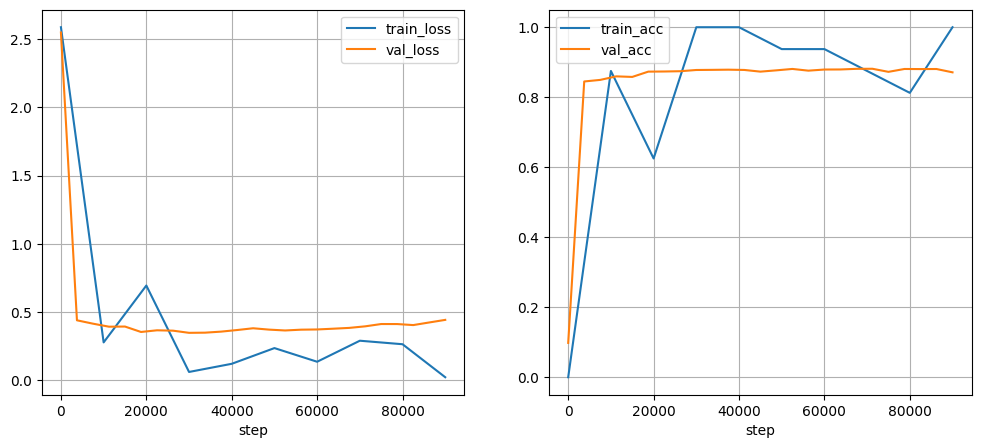

In [37]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(6 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        axs[idx].set_xlabel("step")

    plt.show()

plot_learning_curves(record, sample_step=10000)  #横坐标是 steps

In [38]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/best.ckpt", weights_only=True,map_location="cpu"))

model.eval()
loss, acc = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.3712
accuracy: 0.8791
